In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from collections import defaultdict
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [2]:
df = pd.read_csv('rmse_ts.csv', index_col='id')
df0 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
2,0.005965,0.030530,0.038409,0.052510,0.081335,0.096664,0.092021,0.083451,0.083296,0.086539,...,0.167174,0.126127,0.111858,0.095006,0.099327,0.097803,0.107587,0.152822,0.177150,0.000000
3,0.009710,0.088201,0.120011,0.128533,0.150989,0.169258,0.205793,0.261233,0.279276,0.259404,...,0.126499,0.103162,0.147984,0.207548,0.256682,0.254089,0.194205,0.146202,0.119663,0.121850
5,0.004292,0.036312,0.051975,0.046670,0.203390,0.283229,0.314644,0.322023,0.293859,0.251127,...,0.318426,0.312173,0.305558,0.281919,0.234308,0.178978,0.163058,0.143980,0.120217,0.107188
10,0.110271,0.142744,0.156790,0.131847,0.125279,0.129176,0.128395,0.171358,0.298087,0.304533,...,0.296138,0.217364,0.184314,0.176318,0.161866,0.158079,0.158619,0.148111,0.146005,0.000000
20,0.245351,0.239747,0.211342,0.181047,0.184478,0.177384,0.142504,0.206317,0.242042,0.226818,...,0.333991,0.285059,0.176683,0.181024,0.188473,0.168699,0.164692,0.181571,0.183699,0.000000


# Preprocessing

In [3]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

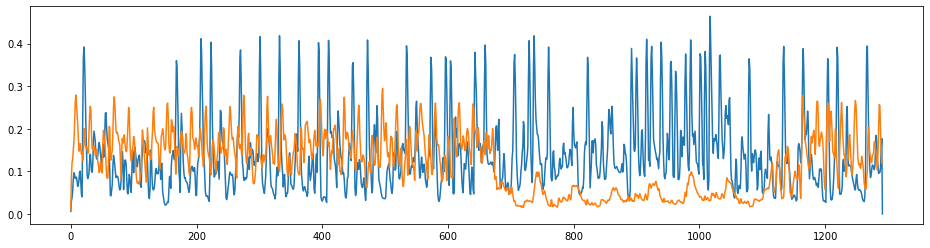

In [4]:
plt.figure(figsize=(16, 4))

ts1 = df[df.index==2].T.values
ts2 = df[df.index==3].T.values

plt.plot(ts1)
plt.plot(ts2)
plt.show()

## Amplitude Scaling

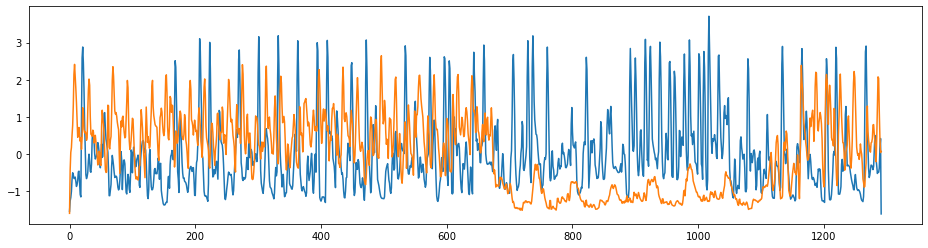

In [5]:
plt.figure(figsize=(16, 4))

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)  # Rescale time series
ts1_scaled = scaler.fit_transform(ts1.reshape(1, -1)).flatten()
ts2_scaled = scaler.fit_transform(ts2.reshape(1, -1)).flatten()

plt.plot(ts1_scaled)
plt.plot(ts2_scaled)
plt.show()

## Noise (smoothing)

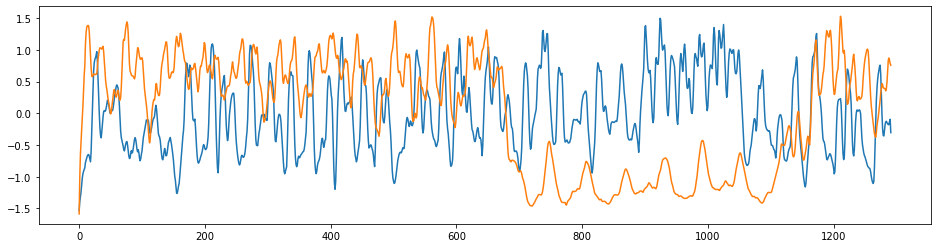

In [6]:
plt.figure(figsize=(16, 4))
w = 10

ts1_ = pd.Series(ts1.reshape(1, -1).squeeze())
ts2_ = pd.Series(ts2.reshape(1, -1).squeeze())

plt.plot(((ts1_ - ts1_.mean())/ts1_.std()).rolling(window=w, min_periods=1).mean())
plt.plot(((ts2_ - ts2_.mean())/ts2_.std()).rolling(window=w, min_periods=1).mean())
plt.show()

In [7]:
#Amplitude scaling df
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
df = df.T.apply(lambda x: scaler.fit_transform(x.values.reshape(1, -1)).flatten()).T

#Noise smoothing df
w = 10
df = df.T.apply(lambda x: ((x - x.mean())/x.std()).rolling(window=w, min_periods=1).mean()).T

# TS Approximation

In [8]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [9]:
ts = df[df.index==2].T.values.reshape(1,-1)

C:\Users\falle\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\falle\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\falle\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


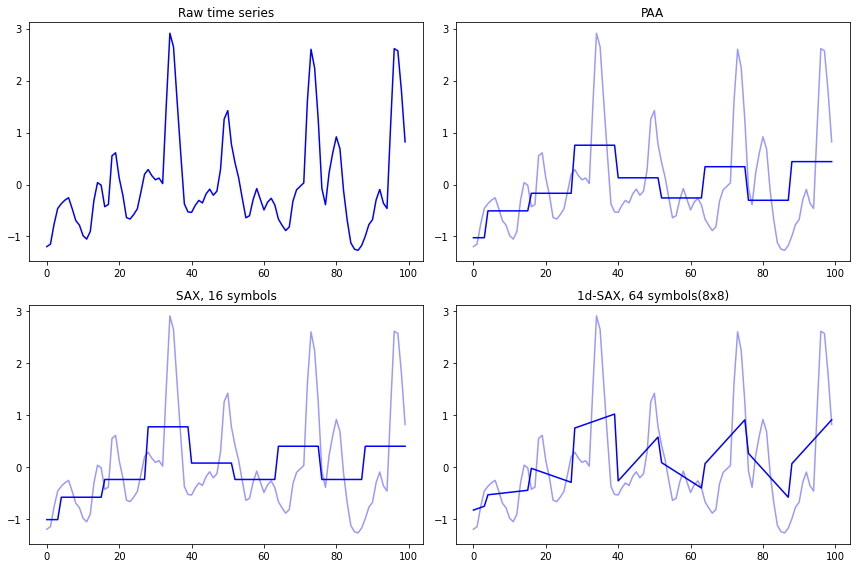

In [10]:
# PAA transform (and inverse transform) of the data
n_paa_segments = 100
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(ts)
paa_dataset_inv = paa.inverse_transform(ts_paa)

# SAX transform
n_sax_symbols = 16
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols, scale=True)
ts_sax = sax.fit_transform(ts)
sax_dataset_inv = sax.inverse_transform(ts_sax)

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)

ts_sax1d = one_d_sax.fit_transform(ts)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(ts_sax1d)

plt.figure(figsize=(12, 8)) 
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(ts[0].ravel()[500:600], "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel()[500:600], "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel()[500:600], "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(ts[0].ravel()[500:600], "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel()[500:600], "b-")
plt.title("1d-SAX, %d symbols"
          "(%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                       n_sax_symbols_avg,
                       n_sax_symbols_slope))

plt.tight_layout()
plt.show()

In [11]:
import warnings
import tqdm as tq
warnings.filterwarnings("ignore")

In [17]:
paa = PiecewiseAggregateApproximation(n_segments=100)
id_list = []
values_list = []
ex = []

for i in tq.tqdm(df.index):
    try:
        values_list.append(paa.fit_transform(df[df.index==i].T.values.reshape(1,-1))[0,:,0])
        id_list.append(i)
    except:
        ex.append(i)

100%|█████████████████████████████████████████████████████████████████████████| 106412/106412 [02:21<00:00, 752.69it/s]


In [18]:
df_approssimato = pd.DataFrame(data=values_list, index=id_list)

In [19]:
df_approssimato

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2,-1.063012,-0.378446,0.425916,0.033017,0.150339,-0.087710,-0.577289,-0.528511,-0.446417,-0.179468,...,0.384126,-0.339522,-0.379817,-0.504463,0.019878,-0.039119,-0.796648,0.869420,-0.114327,-0.700066
3,0.014221,0.995628,0.804789,0.636206,0.192957,0.521068,1.083118,0.746884,0.614796,-0.115630,...,-1.382764,-1.251889,-0.917870,-0.448158,-0.442310,-0.268748,-0.523371,0.691069,0.545334,1.136028
5,-0.409365,0.233493,-0.154301,-0.393842,0.980051,-0.357605,-0.056170,-0.456842,0.977428,0.550632,...,0.263550,-0.074440,-0.432167,-0.306305,0.821702,0.729985,0.202820,-0.863294,0.085117,-0.100107
10,-0.806781,-0.329477,-0.418514,0.039598,-0.355800,-0.787906,-0.397974,-0.421388,-0.085806,-0.533490,...,-0.340388,-0.194084,-0.105177,0.168291,0.016004,0.077183,-0.419088,0.238079,-0.241467,0.534076
20,0.385180,0.805499,-0.266433,-0.158946,0.295217,-0.266670,0.329794,-0.496221,0.907315,0.589161,...,-0.172556,-0.910591,-0.087648,0.433970,1.334203,1.035461,0.620535,0.688058,0.368913,0.363428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148531,0.335927,1.066105,0.390648,-0.796923,0.179508,-0.235022,-0.888049,-1.065139,-0.932360,-1.727303,...,0.178437,0.519667,0.937368,0.699641,-0.215144,-0.306399,0.539079,0.194502,0.844774,0.656468
148532,-0.266527,0.786347,0.912746,0.202720,0.158320,1.979581,1.033920,0.385348,-0.749971,-0.532672,...,-0.523338,-1.298892,-0.312120,0.613477,-0.018867,0.403054,-0.043203,-0.882864,-0.154994,-0.155415
148533,-0.262287,0.186275,0.282665,0.851774,0.167327,1.066599,0.725673,1.404498,0.193719,0.550371,...,0.751087,-0.432827,0.513610,-0.036069,-0.046865,-0.006461,0.567903,-0.297615,-0.844063,-0.363696
148534,-1.122001,-0.490855,-0.010177,1.230833,0.365309,0.548412,-0.023110,-0.555006,-0.760622,-0.356738,...,0.118543,0.074849,-0.796046,-0.452740,-0.434151,1.075671,0.730233,1.113732,0.859832,0.035264


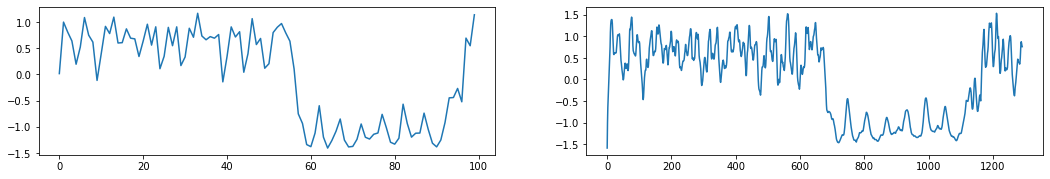

In [20]:
plt.figure(figsize=(18, 6)) 
plt.subplot(2,2,1)
plt.plot(df_approssimato.T[3])
plt.subplot(2,2,2)
plt.plot(df.T[3].values)
plt.show()

In [112]:
#df_approssimato.to_csv("rmse_approssimato.csv")

In [12]:
df0[df0["TRACK_genre_top"] == "Rock"].groupby("ARTIST_name").size().sort_values(ascending=False)

ARTIST_name
Disco Missile            144
Obits                    126
+HIRS+                   100
King Ghidorah!            86
Glove Compartment         75
                        ... 
Seven Lines                1
Krallice                   1
Delusions of Grandeur      1
Male Nudity                1
Jaw Horse                  1
Length: 2054, dtype: int64

In [13]:
indici_disco_missile  = df0[df0["ARTIST_name"] == "Disco Missile"].index
indici_obits  = df0[df0["ARTIST_name"] == "Obits"].index

In [14]:
df_disco_missile = df[df.index.isin(indici_disco_missile)]
df_disco_missile = df_disco_missile.dropna()

df_obits = df[df.index.isin(indici_obits)]
df_obits = df_obits.dropna()

df_artist = df_disco_missile.append(df_obits)

In [15]:
indici_rock  = df0[df0["TRACK_genre_top"] == "Rock"].index
indici_classical  = df0[df0["TRACK_genre_top"] == "Classical"].index
indici_other  = df0[df0["TRACK_genre_top"] != "Rock"].index

In [15]:
df_rock_appr = df_approssimato[df_approssimato.index.isin(indici_rock)]
df_rock_appr = df_rock_appr.dropna()
df_other_appr = df_approssimato[df_approssimato.index.isin(indici_other)]
df_other_appr = df_other_appr.dropna()
df_unito_appr = df_rock_appr[:2000].append(df_other_appr[:2000])

NameError: name 'df_approssimato' is not defined

In [122]:
df_rock = df[df.index.isin(indici_rock)]
df_rock = df_rock.dropna()
df_rock = df_rock.drop(df_rock[df_rock["0"] == 0].index)

df_classical = df[df.index.isin(indici_classical)]
df_classical = df_classical.dropna()

#df_other = df[df.index.isin(indici_other)]
#df_other = df_other.dropna()

df_unito = df_rock[5000:6212].append(df_classical)
#df_unito = df_rock.append(df_classical)

In [123]:
print("df_rock: ", df_rock.shape)
print("df_classical: ", df_classical.shape)
print("df_unito: ", df_unito.shape)
df_unito

df_rock:  (14143, 1292)
df_classical:  (1212, 1292)
df_unito:  (2424, 1292)


,0,1,2,3,4,5,6,7,8,9,...,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291
id,,,,,,,,,,,,,,,,,,,,,
52569,-0.051237,-0.021163,-0.195297,-0.633459,-1.060727,-1.381894,-0.229773,1.739005,1.998651,0.860165,...,0.234416,1.334199,1.292023,0.924732,0.391000,-0.235554,-0.669114,-1.068708,-0.553319,-3.986533
52693,-5.315529,-1.607850,0.278836,0.031710,-0.497278,-0.196666,-0.427250,-1.038352,-1.353696,-1.359871,...,-0.151786,0.363432,-0.148298,-0.408033,0.268431,0.153973,-0.175186,-0.250748,-0.653052,-0.940521
52694,-4.504088,-1.108870,0.630635,0.412185,1.562278,2.117777,0.777156,-0.028122,-0.400641,-0.679126,...,-0.455378,-0.560540,-0.807100,-0.513763,0.041177,-0.240006,-0.148463,2.040832,2.175530,0.276808
52695,-2.680721,-1.130576,-0.025157,0.298899,0.154420,0.070229,-0.017023,0.032498,0.118561,-0.087509,...,-0.142995,-0.787856,-1.377220,-1.465765,-1.674095,-2.205826,-2.384732,-2.294656,-2.029492,-1.394067
52696,-5.138505,-1.202274,0.453726,0.145998,-0.605749,-0.449870,0.247594,-0.054900,0.039662,0.087401,...,-0.801866,-0.758576,0.426819,1.449141,1.135552,0.231232,0.062272,-0.477342,-0.057271,0.323275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146001,-1.542069,-0.342301,0.222933,-0.143969,-0.489144,-0.049846,0.254560,0.181799,-0.093334,-0.316788,...,-1.439909,-1.510992,-1.555486,-1.597589,-1.631354,-1.632002,-1.428285,-0.928698,1.253358,-1.959239
146002,-1.395356,-0.114107,0.602058,0.587982,0.598034,0.453964,0.140441,-0.050605,-0.380355,0.025671,...,-0.335238,-0.421481,-0.515686,-0.631346,-0.767948,-0.821239,-0.758830,-0.643767,-0.536003,-1.542692
148488,-5.784230,-2.367813,-0.821542,-0.213590,1.135568,1.521934,0.699818,-0.026535,-0.023752,0.021735,...,-0.758041,0.150221,0.271611,0.724650,2.757311,3.502880,1.620376,0.016349,0.301884,-0.563684


# Clustering

## Shape-based Clustering

In [18]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from scipy.stats import entropy

### Euclidean

In [161]:
X = df_unito.values
paa = PiecewiseAggregateApproximation(n_segments=100)
X_paa = paa.fit_transform(X)

In [162]:
n_clusters=7
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=50, random_state=0, n_jobs=-1, verbose=True)
km.fit(X_paa)

80.896 --> 52.275 --> 51.059 --> 50.612 --> 50.402 --> 50.261 --> 50.178 --> 50.132 --> 50.097 --> 50.075 --> 50.064 --> 50.056 --> 50.052 --> 50.049 --> 50.047 --> 50.045 --> 50.045 --> 50.045 --> 50.044 --> 50.043 --> 50.042 --> 50.042 --> 50.041 --> 50.041 --> 50.041 --> 50.041 --> 50.041 --> 


TimeSeriesKMeans(n_clusters=7, n_jobs=-1, random_state=0, verbose=True)

In [163]:
km.cluster_centers_.shape

(7, 100, 1)

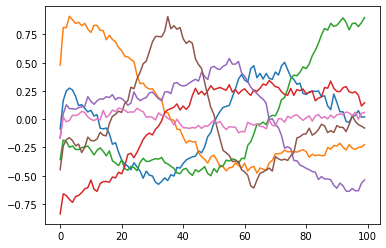

In [164]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [165]:
silhouette_avg = silhouette_score(X, km.labels_)
silhouette_avg

0.0160406361181621

In [166]:
km.inertia_

50.04106106100966

In [167]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([261, 269, 234, 354, 343, 192, 771], dtype=int64))

In [168]:
for i in range(n_clusters):
    n_rock = (np.where(km.labels_ == i)[0] < 1212).sum()
    n_classical = (np.where(km.labels_ == i)[0] >= 1212).sum()
    totale = (km.labels_ == i).sum()
    
    print("#Rock in cluster", i ,"=", n_rock, 
          "#Classical in cluster", i ,"=", n_classical,
          "Rapporto =", n_rock/n_classical
          #"Entropia =", entropy([n_rock/totale, n_classical/totale])
         )

#Rock in cluster 0 = 104 #Classical in cluster 0 = 157 Rapporto = 0.6624203821656051
#Rock in cluster 1 = 108 #Classical in cluster 1 = 161 Rapporto = 0.6708074534161491
#Rock in cluster 2 = 80 #Classical in cluster 2 = 154 Rapporto = 0.5194805194805194
#Rock in cluster 3 = 165 #Classical in cluster 3 = 189 Rapporto = 0.873015873015873
#Rock in cluster 4 = 154 #Classical in cluster 4 = 189 Rapporto = 0.8148148148148148
#Rock in cluster 5 = 59 #Classical in cluster 5 = 133 Rapporto = 0.44360902255639095
#Rock in cluster 6 = 542 #Classical in cluster 6 = 229 Rapporto = 2.3668122270742358


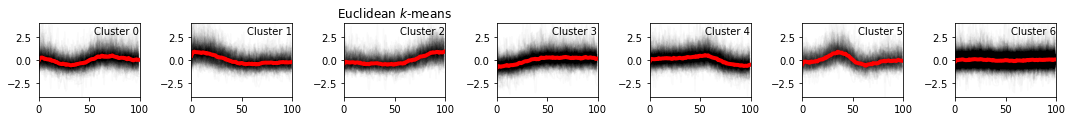

In [27]:
sz = X_paa.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_paa[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

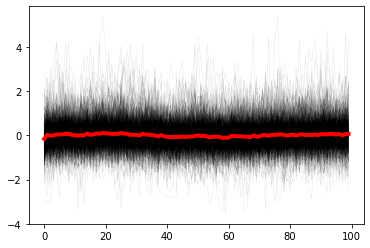

In [28]:
plt.plot(X_paa[np.where(km.labels_ == 6)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km.cluster_centers_[6]).T, linewidth=4, c="r")
plt.show()

### DTW

In [29]:
X = df_unito.values
paa = PiecewiseAggregateApproximation(n_segments=100)
X_paa = paa.fit_transform(X)

In [30]:
n_clusters=5
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0, n_jobs=-1, max_iter_barycenter=10, verbose=True)
km_dtw.fit(X_paa)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2424 out of 2424 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=

25.813 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

17.959 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

17.535 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

17.285 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

17.181 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 11234 tasks  

TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw', n_clusters=5,
                 n_jobs=-1, random_state=0, verbose=True)

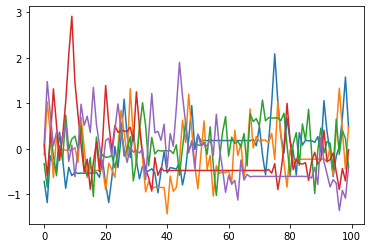

In [31]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [32]:
km_dtw.labels_

array([2, 0, 2, ..., 2, 1, 2], dtype=int64)

In [33]:
km_dtw.inertia_

17.180605094665342

In [34]:
for i in range(n_clusters):
    n_rock = (np.where(km_dtw.labels_ == i)[0] < 1212).sum()
    n_classical = (np.where(km_dtw.labels_ == i)[0] >= 1212).sum()
    totale = (km_dtw.labels_ == i).sum()
    
    print("#Rock in cluster", i ,"=", n_rock, 
          "#Classical in cluster", i ,"=", n_classical,
          "Rapporto =", n_rock/n_classical
          #"Entropia =", entropy([n_rock/totale, n_classical/totale])
         )

#Rock in cluster 0 = 168 #Classical in cluster 0 = 300 Rapporto = 0.56
#Rock in cluster 1 = 239 #Classical in cluster 1 = 316 Rapporto = 0.7563291139240507
#Rock in cluster 2 = 555 #Classical in cluster 2 = 117 Rapporto = 4.743589743589744
#Rock in cluster 3 = 85 #Classical in cluster 3 = 266 Rapporto = 0.31954887218045114
#Rock in cluster 4 = 165 #Classical in cluster 4 = 212 Rapporto = 0.7783018867924528


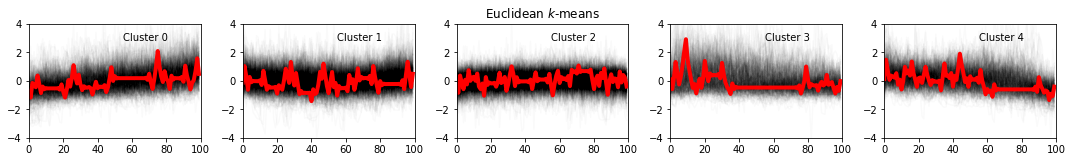

In [35]:
sz = X_paa.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_paa[km_dtw.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km_dtw.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

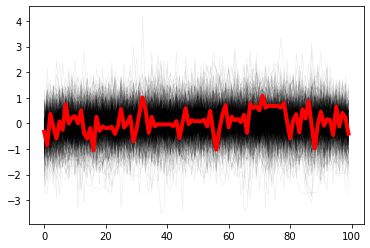

In [36]:
plt.plot(X_paa[np.where(km_dtw.labels_ == 2)[0]].T.squeeze(), c='black', alpha=0.09, linewidth=0.5)
plt.plot(np.squeeze(km_dtw.cluster_centers_[2]).T, linewidth=4, c="r")
plt.show()

### Soft dtw

In [37]:
X = df_unito.values
paa = PiecewiseAggregateApproximation(n_segments=100)
X_paa = paa.fit_transform(X)

In [38]:
n_clusters=5
km_sdtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=5, random_state=0, n_jobs=-1, verbose=True)
km_sdtw.fit(X_paa)

5934.932 --> 11421.330 --> 11657.836 --> 11738.730 --> 11770.731 --> 


TimeSeriesKMeans(max_iter=5, metric='softdtw', n_clusters=5, n_jobs=-1,
                 random_state=0, verbose=True)

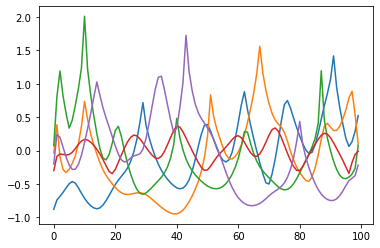

In [39]:
plt.plot(np.squeeze(km_sdtw.cluster_centers_).T)
plt.show()

In [40]:
km_sdtw.labels_

array([3, 0, 3, ..., 3, 0, 3], dtype=int64)

In [41]:
km_sdtw.inertia_

11770.731206267095

In [42]:
for i in range(n_clusters):
    n_rock = (np.where(km_sdtw.labels_ == i)[0] < 1212).sum()
    n_classical = (np.where(km_sdtw.labels_ == i)[0] >= 1212).sum()
    totale = (km_sdtw.labels_ == i).sum()
    
    print("#Rock in cluster", i ,"=", n_rock, 
          "#Classical in cluster", i ,"=", n_classical,
          "Rapporto =", n_rock/n_classical
          #"Entropia =", entropy([n_rock/totale, n_classical/totale])
         )

#Rock in cluster 0 = 176 #Classical in cluster 0 = 278 Rapporto = 0.6330935251798561
#Rock in cluster 1 = 83 #Classical in cluster 1 = 236 Rapporto = 0.3516949152542373
#Rock in cluster 2 = 110 #Classical in cluster 2 = 239 Rapporto = 0.4602510460251046
#Rock in cluster 3 = 687 #Classical in cluster 3 = 149 Rapporto = 4.610738255033557
#Rock in cluster 4 = 156 #Classical in cluster 4 = 309 Rapporto = 0.5048543689320388


## Features-based Clustering

In [44]:
from sklearn.cluster import KMeans
from tsfresh.feature_extraction import extract_features

In [69]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        'min': np.min(values),
        'max': np.max(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values),
        'mad': stats. median_abs_deviation(values),
        #'mode': stats.mode(values)
    }

    return features

In [70]:
X = df_unito.values
paa = PiecewiseAggregateApproximation(n_segments=100)
X_paa = paa.fit_transform(X)

F = [list(calculate_features(x).values())[:-2] for x in X_paa]

In [71]:
n_clusters=6
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(F)

KMeans(n_clusters=6)

In [72]:
kmeans.inertia_

1406.8129731422841

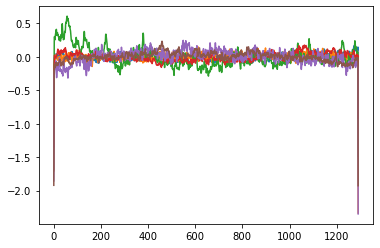

In [73]:
for i in range(n_clusters):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

In [74]:
for i in range(n_clusters):
    n_rock = (np.where(kmeans.labels_ == i)[0] < 1212).sum()
    n_classical = (np.where(kmeans.labels_ == i)[0] >= 1212).sum()
    totale = (kmeans.labels_ == i).sum()
    
    print("#Rock in cluster", i ,"=", n_rock, 
          "#Classical in cluster", i ,"=", n_classical,
          "Rapporto =", n_rock/n_classical
          #"Entropia =", entropy([n_rock/totale, n_classical/totale])
         )

#Rock in cluster 0 = 235 #Classical in cluster 0 = 429 Rapporto = 0.5477855477855478
#Rock in cluster 1 = 514 #Classical in cluster 1 = 38 Rapporto = 13.526315789473685
#Rock in cluster 2 = 21 #Classical in cluster 2 = 71 Rapporto = 0.29577464788732394
#Rock in cluster 3 = 69 #Classical in cluster 3 = 359 Rapporto = 0.19220055710306408
#Rock in cluster 4 = 177 #Classical in cluster 4 = 36 Rapporto = 4.916666666666667
#Rock in cluster 5 = 196 #Classical in cluster 5 = 278 Rapporto = 0.7050359712230215


Euclidean k-means
67.928 --> 39.675 --> 38.863 --> 38.698 --> 38.644 --> 38.612 --> 38.580 --> 38.559 --> 38.536 --> 38.516 --> 38.494 --> 38.455 --> 38.410 --> 38.371 --> 38.343 --> 38.315 --> 38.300 --> 38.297 --> 38.293 --> 38.289 --> 38.283 --> 38.278 --> 38.275 --> 38.274 --> 38.273 --> 38.273 --> 
DBA k-means


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished
[Parall

17.600 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


14.320 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


14.097 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


13.960 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


13.886 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


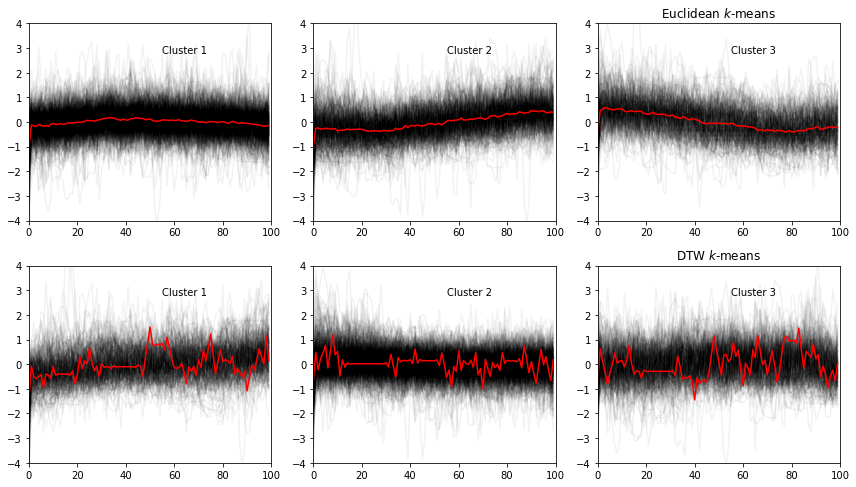

In [145]:
# Plot from https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py
X = df_unito.values
sz = X.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=0, n_jobs=-1, max_iter=50)
km.fit(X)

plt.figure(figsize=(12, 10)) 
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=0,
                          n_jobs=-1,
                          max_iter=5)
dba_km.fit(X)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X[dba_km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.05)
    plt.plot(np.squeeze(dba_km.cluster_centers_[yi]).T, "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("DTW $k$-means")

plt.tight_layout()
plt.show()

# Clustering per Motif

In [19]:
from scipy.spatial.distance import pdist, squareform

In [194]:
X = df_rock[:6000].values
#paa = PiecewiseAggregateApproximation(n_segments=200)
#X_paa = paa.fit_transform(X)
#one_d_sax = OneD_SymbolicAggregateApproximation(n_segments=100,alphabet_size_avg=8,alphabet_size_slope=8)
#X_paa = one_d_sax.fit_transform(X)[:,:,0]

In [195]:
n_clusters=4
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=50, random_state=0, n_jobs=-1, verbose=True)
km.fit(X)

2184.868 --> 1213.602 --> 1205.761 --> 1202.114 --> 1200.742 --> 1200.278 --> 1200.103 --> 1200.026 --> 1199.968 --> 1199.912 --> 1199.867 --> 1199.833 --> 1199.817 --> 1199.803 --> 1199.793 --> 1199.782 --> 1199.768 --> 1199.754 --> 1199.735 --> 1199.714 --> 1199.699 --> 1199.679 --> 1199.668 --> 1199.659 --> 1199.651 --> 1199.646 --> 1199.644 --> 1199.641 --> 1199.640 --> 1199.639 --> 1199.637 --> 1199.635 --> 1199.634 --> 1199.632 --> 1199.632 --> 1199.632 --> 1199.631 --> 1199.631 --> 1199.631 --> 


TimeSeriesKMeans(n_clusters=4, n_jobs=-1, random_state=0, verbose=True)

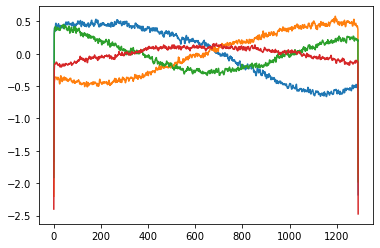

In [196]:
plt.plot(np.squeeze(km.cluster_centers_).T)
plt.show()

In [197]:
unique, counts = np.unique(km.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int64),
 array([ 949, 1164, 1264, 2623], dtype=int64))

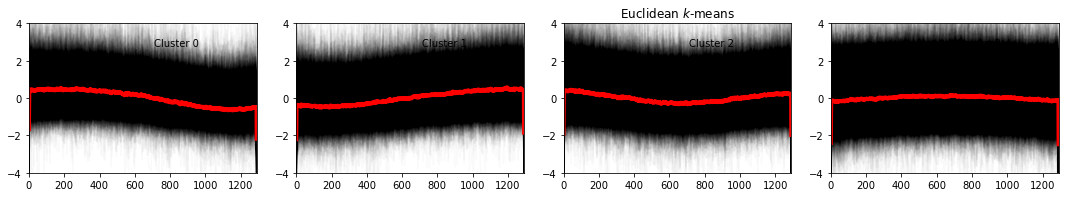

In [198]:
sz = X.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X[km.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

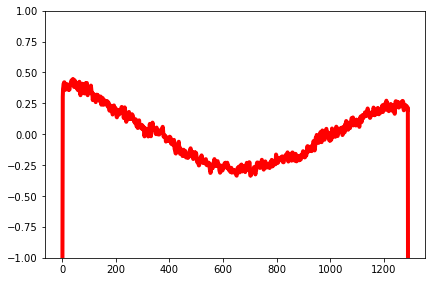

In [199]:
plt.figure(figsize=(15, 10))
plt.subplot(2,2,1)
plt.ylim([-1,1])
plt.plot(np.squeeze(km.cluster_centers_[2]).T, linewidth=4, c="r")
plt.show()

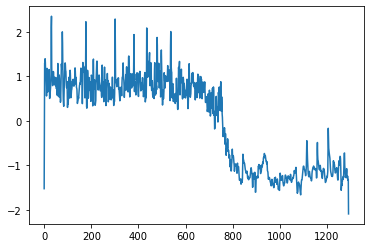

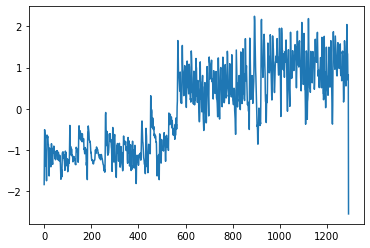

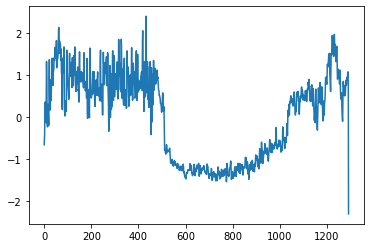

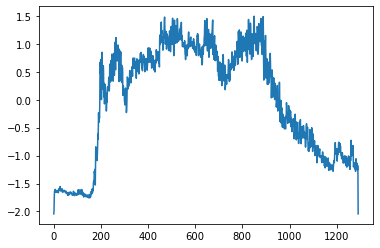

In [200]:
idx0 = np.argmin(np.sum(squareform(pdist(X[np.where(km.labels_ == 0)[0]])), axis=0))
idx1 = np.argmin(np.sum(squareform(pdist(X[np.where(km.labels_ == 1)[0]])), axis=0))
idx2 = np.argmin(np.sum(squareform(pdist(X[np.where(km.labels_ == 2)[0]])), axis=0))
idx3 = np.argmin(np.sum(squareform(pdist(X[np.where(km.labels_ == 3)[0]])), axis=0))
#idx4 = np.argmin(np.sum(squareform(pdist(X[np.where(km.labels_ == 4)[0]])), axis=0))

ts0 = X[np.where(km.labels_ == 0)[0]][idx0]
ts1 = X[np.where(km.labels_ == 1)[0]][idx1]
ts2 = X[np.where(km.labels_ == 2)[0]][idx2]
ts3 = X[np.where(km.labels_ == 3)[0]][idx3]
#ts4 = X[np.where(km.labels_ == 4)[0]][idx4]

plt.plot(ts0)    
plt.show()
plt.plot(ts1)    
plt.show()
plt.plot(ts2)    
plt.show()
plt.plot(ts3)    
plt.show()
#plt.plot(ts4)    
#plt.show()

In [174]:
X_ = df_rock[5000:5800].values
paa = PiecewiseAggregateApproximation(n_segments=200)
X_paa = paa.fit_transform(X_)

In [175]:
n_clusters=4
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=5, random_state=0, n_jobs=-1, max_iter_barycenter=10, verbose=True)
km_dtw.fit(X_paa)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent 

49.283 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:    1.0s finished


38.826 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:    0.9s finished


38.145 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:    1.0s finished


37.832 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:    0.9s finished


37.634 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:    1.0s finished


TimeSeriesKMeans(max_iter=5, max_iter_barycenter=10, metric='dtw', n_clusters=4,
                 n_jobs=-1, random_state=0, verbose=True)

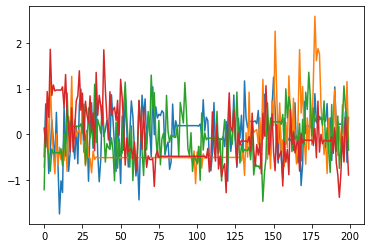

In [176]:
plt.plot(np.squeeze(km_dtw.cluster_centers_).T)
plt.show()

In [177]:
unique, counts = np.unique(km_dtw.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int64), array([238, 195, 208, 159], dtype=int64))

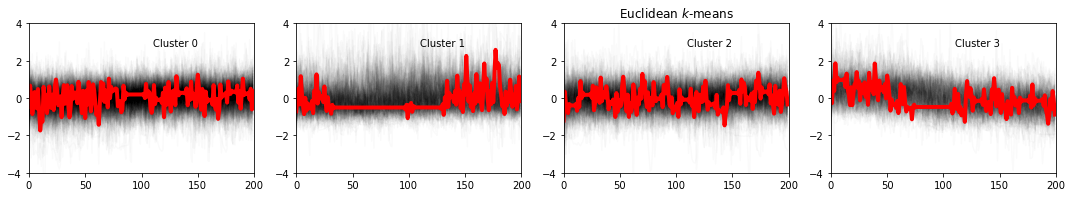

In [178]:
sz = X_paa.shape[1]
plt.figure(figsize=(15, 10)) 
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_paa[km_dtw.labels_ == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.02)
    plt.plot(np.squeeze(km_dtw.cluster_centers_[yi]).T, "r-", linewidth=4)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    if yi == 2:
        plt.title("Euclidean $k$-means")
        
plt.tight_layout()
plt.show()

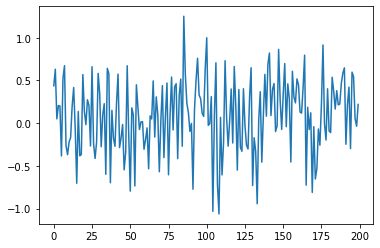

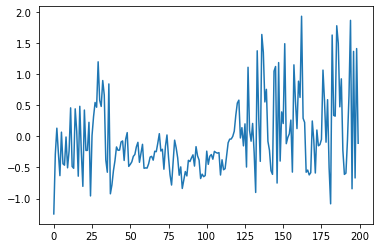

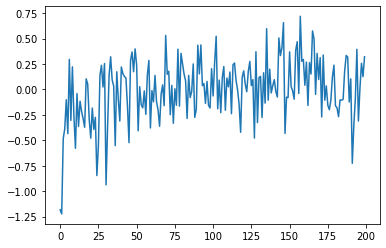

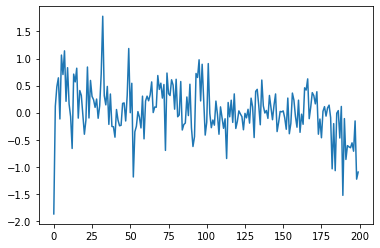

In [181]:
X_paa = X_paa.squeeze()

idx0 = np.argmin(np.sum(squareform(pdist(X_paa[np.where(km_dtw.labels_ == 0)[0]])), axis=0))
idx1 = np.argmin(np.sum(squareform(pdist(X_paa[np.where(km_dtw.labels_ == 1)[0]])), axis=0))
idx2 = np.argmin(np.sum(squareform(pdist(X_paa[np.where(km_dtw.labels_ == 2)[0]])), axis=0))
idx3 = np.argmin(np.sum(squareform(pdist(X_paa[np.where(km_dtw.labels_ == 3)[0]])), axis=0))
#idx4 = np.argmin(np.sum(squareform(pdist(X[np.where(km.labels_ == 4)[0]])), axis=0))

ts0 = X_paa[np.where(km_dtw.labels_ == 0)[0]][idx0]
ts1 = X_paa[np.where(km_dtw.labels_ == 1)[0]][idx1]
ts2 = X_paa[np.where(km_dtw.labels_ == 2)[0]][idx2]
ts3 = X_paa[np.where(km_dtw.labels_ == 3)[0]][idx3]
#ts4 = X[np.where(km.labels_ == 4)[0]][idx4]

plt.plot(ts0)    
plt.show()
plt.plot(ts1)    
plt.show()
plt.plot(ts2)    
plt.show()
plt.plot(ts3)    
plt.show()
#plt.plot(ts4)    
#plt.show()

In [201]:
#Export
import pickle

np.savetxt("X_paa.csv", X_paa, delimiter=",")
np.savetxt("X.csv", X, delimiter=",")
pickle.dump(km, open("euclidean.pickle", 'wb'))
pickle.dump(km_dtw, open("dtw.pickle", 'wb'))